# Pay Analaysis Dashboard

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from sqlalchemy import create_engine

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = [8, 6]

In [5]:
def load_data_from_db():
    df = pd.read_sql_table('pay_analysis_data', conn, index_col='emp_id')
    return df

In [272]:
# Get the data for analysis
engine = create_engine("postgresql://Joachim:@localhost/tm470")
conn = engine.connect()
people_df = load_data_from_db()
conn.close()

In [273]:
# Create additional columns
people_df['payband'] = people_df.payband_id.apply(lambda x: 'P{}'.format(x))

# Make age group to categorical to show in correct order
age_groups = ['30-39', '40-49', '50-59', '60-69']
people_df['age_group'] = people_df['age_group'].astype('category', categories=age_groups)

# Add age as one number (upper of age group) 
# Add months of service
ages = people_df['age_group'].astype(str)
people_df['age'] = ages.str.extract('\d\d-?(\d\d)').astype(np.int64)
people_df['months_of_service'] = (date.today() - people_df['hire_date']).astype('timedelta64[M]')

## Workforce composition

The following table shows the current staff numbers and salary information

In [274]:
summary_df = people_df.groupby(['payband'])['salary','fte','headcount'].aggregate({
    'salary': ['min', 'max', np.mean, np.median],
    'fte': np.sum,
    'headcount': np.size
})
summary_df.round(1).style.format('{:,}')

### Gender composition by payband

In [275]:
labels = ['Female', 'Male']

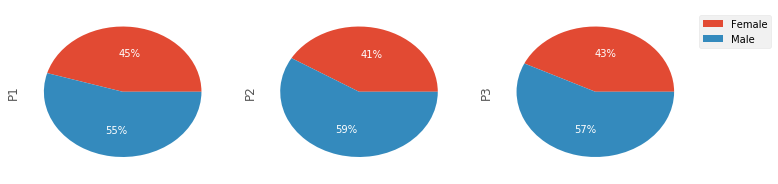

In [276]:
gender_df = pd.crosstab(people_df.gender, people_df.payband)
ax1,ax2,ax3 = gender_df.plot.pie(subplots=True, figsize=(12,3), legend=False, labels=labels, 
                   autopct='%1.0f%%', textprops={'color':'white'})
plt.legend(bbox_to_anchor=(1,1), fancybox=True, framealpha=0.5)
plt.show()

### Age

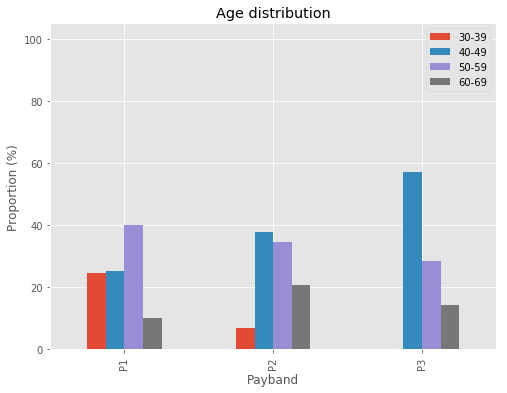

In [277]:
age_df = people_df[['payband','age_group','headcount']].groupby(['payband','age_group']).agg({'headcount':'sum'})

# Calculate percentages within grades
age_percent = age_df.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
age_percent = age_percent.reset_index()

# Plot
age_percent.pivot('payband', 'age_group').plot.bar(legend=False)
plt.legend(age_groups, loc='best')
plt.ylabel('Proportion (%)')
plt.xlabel('Payband')
plt.ylim(0,105)
plt.title('Age distribution');

In [278]:
# Another way of achieving the above, new since v0.20
df = pd.crosstab(people_df['age_group'], people_df['payband'])
# df.transform(lambda x: 100 * x / float(x.sum())).transpose().plot.bar(ylim=[0,100])

### Working pattern

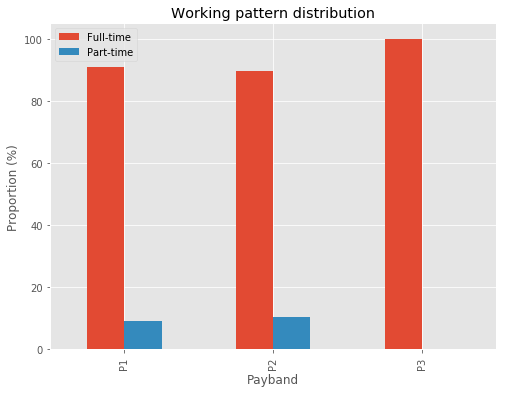

In [279]:
ft_pt_df = people_df[['payband','work_pattern','headcount']].groupby(['payband','work_pattern']).agg(
    {'headcount':'sum'})

# Calculate percentages within paybands
ft_pt_percent = ft_pt_df.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
ft_pt_percent = ft_pt_percent.reset_index()

# Plot
ft_pt_percent.pivot('payband', 'work_pattern').plot.bar(legend=False)
plt.legend(['Full-time','Part-time'], loc='best')
plt.ylabel('Proportion (%)')
plt.xlabel('Payband')
plt.title('Working pattern distribution');

# Salary distribution

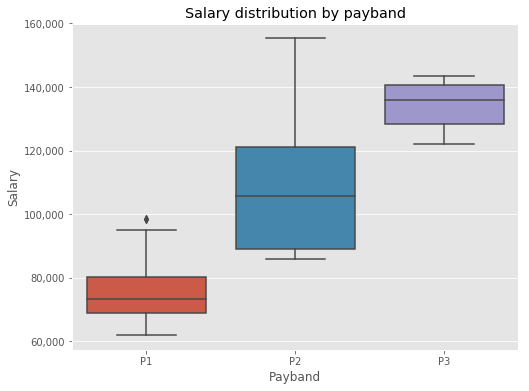

In [288]:
g = sns.boxplot(x='payband', y='salary', data=people_df)
g.set_xlabel('Payband')
g.set_ylabel('Salary')
g.set_title('Salary distribution by payband')
# Format salary labels with a thousand comma
g.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show(g)

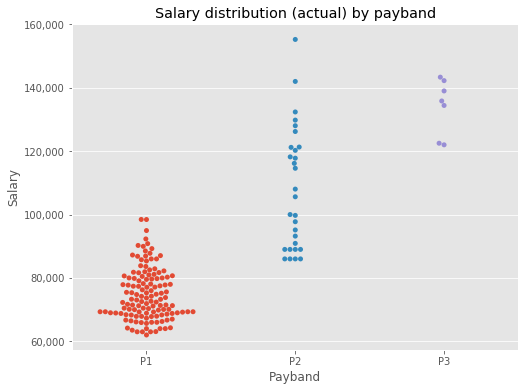

In [290]:
g = sns.swarmplot(x='payband', y='salary', data=people_df)
# g = sns.swarmplot(x='payband', y='salary', data=people_df, color='.25')
g.set_xlabel('Payband')
g.set_ylabel('Salary')
g.set_title('Salary distribution (actual) by payband')
# Format salary labels with a thousand comma
g.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show(g)

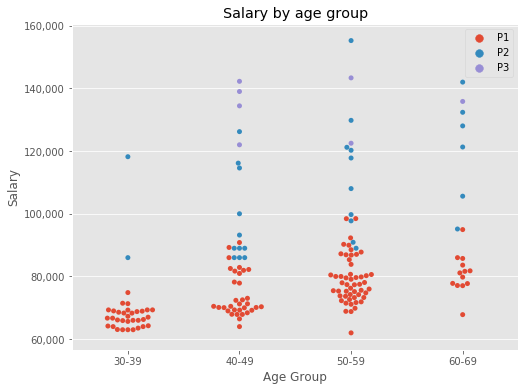

In [281]:
g = sns.swarmplot(x='age_group', y='salary', data=people_df, hue='payband')
g.set_title('Salary by age group')
g.set_ylabel('Salary')
g.set_xlabel('Age Group')
g.legend(loc='best')
# Format salary labels with a thousand comma
g.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show(g)

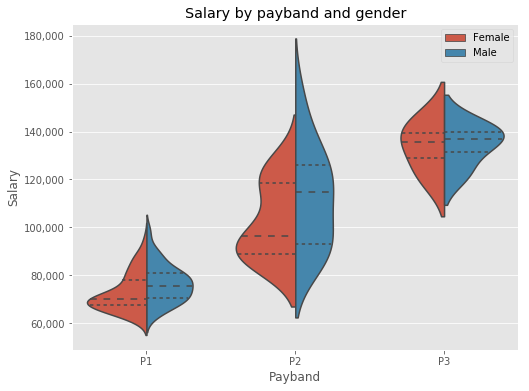

In [148]:
g = sns.violinplot(x='payband', y='salary', data=people_df, hue='gender', split=True, inner='quartiles')
g.set_title('Salary by payband and gender')
g.set_ylabel('Salary')
g.set_xlabel('Payband')
# Format salary labels with a thousand comma
g.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.legend(loc='best')
plt.show(g)